In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
n_choices = 100

In [3]:
rewards = torch.randn(n_choices)
rewards

tensor([-0.4595, -0.1203, -0.1702, -0.2653, -0.6857, -0.6347,  1.1472, -1.4484,
        -0.5250, -0.4867, -0.7117, -1.1879, -0.4408,  0.3807,  1.6300,  0.5331,
        -0.5031, -0.1922,  2.1876,  0.8341,  0.0367,  0.0706, -0.8035, -1.0539,
         0.8323,  0.9009,  0.8171,  1.0341, -0.2808, -1.7675,  0.9201, -1.1343,
         0.3229, -1.5715, -1.0373, -1.2801, -1.9845,  0.0081, -0.4968,  0.5615,
         0.8020,  0.0312,  1.9523,  0.1756,  1.8664, -0.2495,  0.7780,  0.1735,
         0.1046, -0.3974, -1.7839, -2.0468, -0.9796,  0.0530, -0.6119, -0.4374,
         1.0833, -0.5647,  0.9898,  0.0503, -0.7535, -0.2221,  0.9356, -0.9904,
        -0.9419, -1.4333,  1.4412, -0.3370, -0.4285,  0.5081, -0.3702,  1.3647,
        -1.3594, -0.3157, -1.5216,  0.1786, -0.7397, -0.1130, -1.4725,  1.4103,
        -0.8687,  1.0072, -0.9607, -0.3280, -1.6302, -0.1889, -0.8818, -0.1646,
         0.0707,  0.2263,  1.1492, -0.1294,  0.3577,  0.9364, -0.1232,  0.1978,
         0.0756,  0.4737, -0.3807, -1.01

In [4]:
class Actor(nn.Module):
    def __init__(self, n_out, n_hidden=10):
        super().__init__()
        self.x = torch.ones(1)
        self.layers = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(-1)
        )

    def forward(self):
        return self.layers(self.x)

In [5]:
class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.x = torch.ones(n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class Sampler:
    def __init__(self, weights):
        self.sampler = torch.distributions.categorical.Categorical(weights)
        
    def sample(self, n=1):
        return  self.sampler.sample((n,))

In [7]:
class OneHotEncoder:
    def __init__(self, n):
        self.n = n
        
    def encode(self, x):
        return nn.functional.one_hot(x, self.n)

In [8]:
actor = Actor(n_choices)
critic = Critic(n_choices)

In [9]:
encoder = OneHotEncoder(n_choices)

In [10]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.005)

In [11]:
criterion = nn.MSELoss()

In [12]:
epochs = 1000
actor_iters = 10000
critic_iters = 10

In [13]:
critic_losses = []
actor_rewards = []

for _ in range(epochs):
    critic_optimizer.zero_grad()
    choice = Sampler(actor()).sample(critic_iters)
    x = encoder.encode(choice)
    pred_reward = critic(x.float())
    real_reward = rewards[choice].unsqueeze(-1)
    loss = criterion(pred_reward, real_reward)
    loss.backward()
    critic_optimizer.step()
    
    critic_losses.append(loss.item())
    
    actor_optimizer.zero_grad()
    probs = actor()
    choice = Sampler(probs).sample(actor_iters)
    x = encoder.encode(choice)
    reward = critic(x.float())
    loss = -(reward * torch.log(probs[choice].unsqueeze(-1))).mean()
    loss.backward()
    actor_optimizer.step()
    
    actor_rewards.append(reward.mean().item())

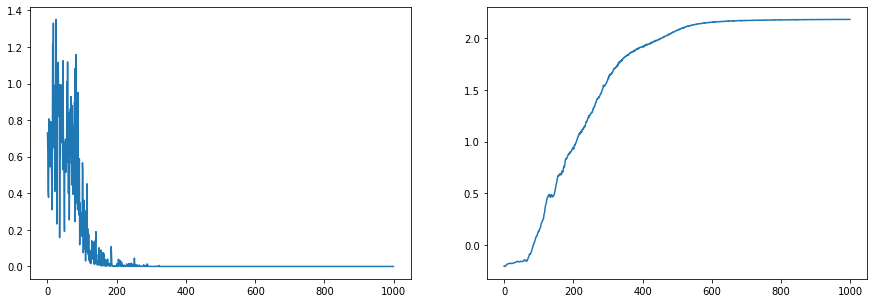

In [14]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(critic_losses)
axs[1].plot(actor_rewards)

<BarContainer object of 100 artists>

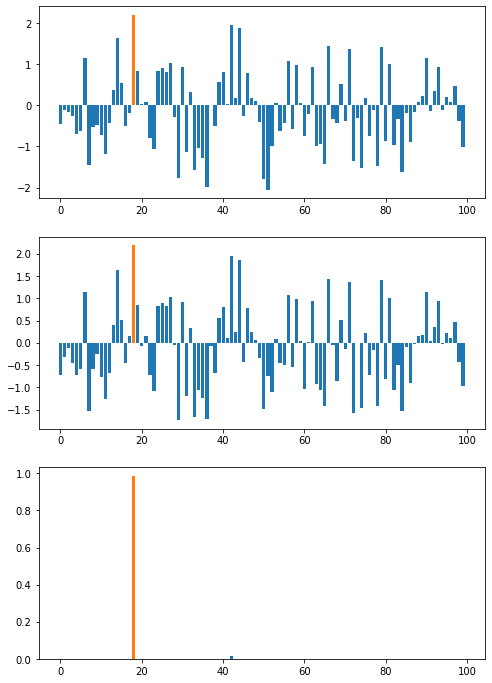

In [15]:
color=['C1' if i == actor().argmax() else 'C0' for i in range(n_choices)]
_, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].bar(range(n_choices), rewards, color=color)
axs[1].bar(range(n_choices), critic(encoder.encode(torch.arange(n_choices)).float()).flatten().detach().numpy(), color=color)
axs[2].bar(range(n_choices), actor().detach().numpy(), color=color)